#### Import training and test datasets

In [1]:
import os
import numpy as np

# Root directory is the second-parent directory of the current file
root_dir = os.path.dirname(os.path.dirname(os.getcwd()))

# Import training data
# First row: column labels as strings (skip)
# Every other row: label (string), pixel data array (28*28 = 784)
train_path = os.path.join(root_dir, "data", "digit-recognizer", "train.csv")
test_path = os.path.join(root_dir, "data", "digit-recognizer", "test.csv")
data_train_raw = np.loadtxt(train_path, delimiter=",", skiprows=1)
data_test_raw = np.loadtxt(test_path, delimiter=",", skiprows=1)

#### Display an image from the dataset

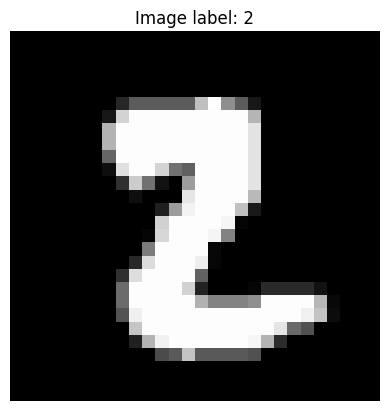

In [3]:
import matplotlib.pyplot as plt

# Select an image
image_num = 16

# Obtain label and pixel data for the image
label = data_train_raw[image_num][0]
image = data_train_raw[image_num][1:].reshape(28,28)

# Display the image and its label
plt.imshow(image, cmap="gray")
plt.axis("off")
plt.title(f"Image label: {int(label)}")
plt.show()

#### Check GPU and CUDA availability

In [1]:
import torch, subprocess

def disp(str1,str2): return print(str1.ljust(15),":",str2)
disp("PyTorch version",torch.__version__)
if not torch.cuda.is_available():
    print("ERROR: no CUDA visible to PyTorch!")
else:
    disp("CUDA available",torch.cuda.is_available())
    disp("CUDA version",torch.version.cuda)
    for i in range(torch.cuda.device_count()):
        p = torch.cuda.get_device_properties(i)
        disp(f"GPU {i}",f"{p.name}")
        disp(f"GPU {i} memory",f"{p.total_memory/1000**3:.2f} GB")

cmd = ['nvidia-smi', 
        '--query-gpu=memory.total,memory.used',
        '--format=csv,noheader,nounits']
out = subprocess.check_output(cmd).decode().strip()
total, used = map(int, out.split(", "))
disp("GPU memory used",f"{used} MiB / {total} MiB")

PyTorch version : 2.9.0+cu128
CUDA available  : True
CUDA version    : 12.8
GPU 0           : NVIDIA A40
GPU 0 memory    : 47.62 GB
GPU memory used : 3 MiB / 46068 MiB


#### Train the model and validate its accuracy

In [ ]:
# Reload Python library at every evaluation
%reload_ext autoreload
%autoreload 2

import torch, time
from model.torch import TorchMLP, TorchMLPNative

# Define PyTorch parameters.
torch.cuda.empty_cache()
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DTYPE = torch.float32

# Inputs:
# For each sample, pixel values in range [0,1], flattened 28x28-pixel image.
inputs = torch.tensor(data_train_raw[:,1:]/255.0, \
    dtype = DTYPE, device = DEVICE)
# Mean subtraction: subtract mean value across dataset to make features balanced.
inputs = (inputs - inputs.mean(0)) / (inputs.std(0)+10**(-9))
# Split data into training and validation datasets.
threshold = int(0.8 * inputs.shape[0])
inputs_train = inputs[:threshold]
inputs_validate = inputs[threshold:]

# Training data:
# For each sample, correct class as a non-negative integer.
data = torch.tensor(data_train_raw[:,0], dtype = torch.long, device = DEVICE)
data_train = data[:threshold]
data_validate = data[threshold:]

# Define MLP structure.
MODEL_TYPE = "classifier"
DIM_INPUT = inputs.shape[1]
if MODEL_TYPE=="classifier":
    DIM_OUTPUT = int(data.max().item()) + 1
NUM_LAYERS = 3
DIM_HIDDEN = 256
ACTIVATION_FUNCTION = "relu"
ACTIVATION_FUNCTION_OUT = "softmax"
OPTIMIZER = "adam"
DROPOUT_RATE = 0.1
# TorchMLP: num_layers, dim_hidden, model_type, dtype, device
# TorchMLPNative: num_layers, dim_hidden, model_type, dtype, device

#MODEL = TorchMLP(num_layers = NUM_LAYERS, dim_hidden = DIM_HIDDEN, \
#    model_type = "classifier", dtype = DTYPE, device = DEVICE)
MODEL = TorchMLPNative(dim_input=DIM_INPUT, dim_output=DIM_OUTPUT, \
    num_layers=NUM_LAYERS, dim_hidden=DIM_HIDDEN, \
    activation_function=ACTIVATION_FUNCTION, \
    activation_function_out=ACTIVATION_FUNCTION_OUT, \
    optimizer=OPTIMIZER, dropout_rate=DROPOUT_RATE, \
    dtype=DTYPE, device=DEVICE)

# Train the model.
epochs, losses, accuracies = \
    MODEL.train_supervised(inputs = inputs_train, targets = data_train, \
    num_epochs = 200, batch_size = 1000, log_step = 20, lr = 0.00001)

# Validate the accuracy.
val_loss, val_acc = MODEL.validate(inputs_validate, data_validate)


/nfs/scistore12/lemesgrp/mmaslov/.python_venv/lib/python3.11/site-packages/torch/backends/cuda/__init__.py:131: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  return torch._C._get_cublas_allow_tf32()
/nfs/scistore12/lemesgrp/mmaslov/.python_venv/lib/python3.11/site-packages/torch/_inductor/compile_fx.py:312: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.w

Epoch 200/200: loss 0.1076, accuracy 0.9688
Validation loss 0.1699, accuracy 0.9513


In [4]:
DEVICE

device(type='cuda')

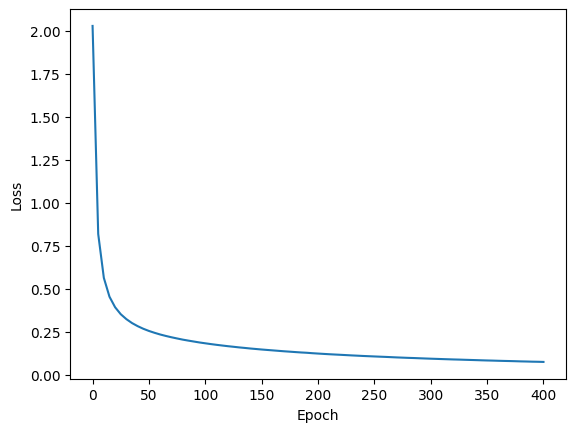

In [11]:
import matplotlib.pyplot as plt
# Plot the losses.
plt.plot(epochs,losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

#### Compare performance of different models

In [20]:
# Reload Python library at every evaluation
%reload_ext autoreload
%autoreload 2

import torch, time
from model.torch import TorchMLP, TorchMLPNative

# Define PyTorch parameters.
torch.cuda.empty_cache()
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DTYPE = torch.float32

# Inputs:
# For each sample, pixel values in range [0,1], flattened 28x28-pixel image.
inputs = torch.tensor(data_train_raw[:,1:]/255.0, \
    dtype = DTYPE, device = DEVICE)
# Mean subtraction: subtract mean value across dataset to make features balanced.
inputs = (inputs - inputs.mean(0)) / (inputs.std(0)+10**(-9))
# Split data into training and validation datasets.
threshold = int(0.8 * inputs.shape[0])
inputs_train = inputs[:threshold]
inputs_validate = inputs[threshold:]

# Training data:
# For each sample, correct class as a non-negative integer.
data = torch.tensor(data_train_raw[:,0], dtype = torch.long, device = DEVICE)
data_train = data[:threshold]
data_validate = data[threshold:]

# Define MLP structure.
MODEL_TYPE = "classifier"
DIM_INPUT = inputs.shape[1]
if MODEL_TYPE=="classifier":
    DIM_OUTPUT = int(data.max().item()) + 1
NUM_LAYERS = 3
DIM_HIDDEN = 256
ACTIVATION_FUNCTION = "relu"
ACTIVATION_FUNCTION_OUT = "softmax"
OPTIMIZER = "SGD"
DROPOUT_RATE = 0.1
MODELS = [TorchMLP, TorchMLPNative]

for MODEL in MODELS:
    print(f"Model: {MODEL.__name__}")
    t0 = time.perf_counter()
    # Initialize model
    model = MODEL(dim_input=DIM_INPUT, dim_output=DIM_OUTPUT, \
        num_layers=NUM_LAYERS, dim_hidden=DIM_HIDDEN, \
        activation_function=ACTIVATION_FUNCTION, \
        activation_function_out=ACTIVATION_FUNCTION_OUT, \
        optimizer=OPTIMIZER, dropout_rate=DROPOUT_RATE, \
        dtype=DTYPE, device=DEVICE)
    # Train the model
    epochs, losses, accuracies = \
        model.train_supervised(inputs = inputs_train, \
        targets = data_train, num_epochs = 1500, batch_size = 1000, \
        log_step = 20, lr = 0.000005)
    # Validate the accuracy
    val_loss, val_acc = model.validate(inputs_validate, data_validate)
    t1 = time.perf_counter()
    print(f"Time: {t1-t0:.4f} seconds\n")

Model: TorchMLP
Epoch 1500/1500: loss 0.4608, accuracy 0.8707
Validation loss 0.4739, accuracy 0.8683
Time: 50.7013 seconds

Model: TorchMLPNative
Epoch 1500/1500: loss 0.4788, accuracy 0.8655
Validation loss 0.4852, accuracy 0.8682
Time: 432.5339 seconds

